# Import Required Libraries
Import the necessary libraries, including PyTorch.

In [12]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Time Series of Observations')

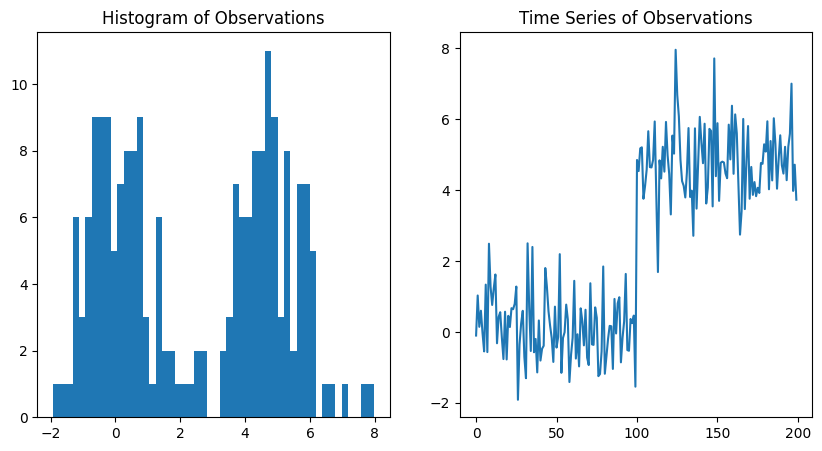

In [35]:
# Generate some observations with two normal distributions randomly mixed
X = np.concatenate([np.random.normal(0, 1, 100), np.random.normal(5, 1, 100)])
#np.random.shuffle(observations)

# Plot histogram and time series
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(X, bins=50)
ax[0].set_title('Histogram of Observations')
ax[1].plot(X)
ax[1].set_title('Time Series of Observations')

# Define the Hidden Markov Model
Define the Hidden Markov Model (HMM) class, including its states and observations.

In [22]:
# Define the Hidden Markov Model
class HMM(nn.Module):
    def __init__(self, num_states, num_observations):
        super(HMM, self).__init__()
        
        # Initialize the transition matrix with uniform distribution
        self.transition = nn.Parameter(torch.ones(num_states, num_states) / num_states, requires_grad=True)
        
        # Initialize the emission matrix with uniform distribution
        self.emission = nn.Parameter(torch.ones(num_states, num_observations) / num_observations, requires_grad=True)
        
        # Initialize the initial state distribution with uniform distribution
        self.initial = nn.Parameter(torch.ones(num_states) / num_states, requires_grad=True)
        
    def forward(self, observations):
        # Implement the forward algorithm
        alpha = self.initial * self.emission[:, observations[0]]
        
        for obs in observations[1:]:
            alpha = self.emission[:, obs] * (self.transition.t() @ alpha)
            
        return alpha.sum()

# Initialize the Model Parameters
Initialize the transition probabilities, emission probabilities, and initial state probabilities.

In [36]:
# add 1 dim to axis 0 of X
X = X[None, :]
X.shape

(1, 200)

In [37]:
# Initialize the Model Parameters
num_states = 2
num_observations = 1

# Create an instance of the HMM
model = HMM(num_states, num_observations)

# Print the initialized parameters
print("Initial state probabilities:\n", model.initial)
print("\nTransition probabilities:\n", model.transition)
print("\nEmission probabilities:\n", model.emission)

Initial state probabilities:
 Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)

Transition probabilities:
 Parameter containing:
tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]], requires_grad=True)

Emission probabilities:
 Parameter containing:
tensor([[1.],
        [1.]], requires_grad=True)


In [38]:
# Test the forward algorithm
probability = model.forward(torch.tensor(X))
print("Probability of observing the sequence given the model parameters: ", probability)

IndexError: tensors used as indices must be long, int, byte or bool tensors

# Implement the Backward Algorithm
Implement the backward algorithm to compute the probability of observing a sequence given the model parameters.

In [5]:
# Implement the Backward Algorithm
def backward_algorithm(self, observations):
    # Initialize the beta vector with ones
    beta = torch.ones(self.transition.shape[0])
    
    # Iterate over the observations in reverse order
    for obs in reversed(observations[1:]):
        # Update the beta vector
        beta = self.transition @ (self.emission[:, obs] * beta)
        
    # Return the dot product of the initial state distribution, the emission probabilities of the first observation, and the beta vector
    return (self.initial * self.emission[:, observations[0]] * beta).sum()

# Add the backward algorithm to the HMM class
HMM.backward_algorithm = backward_algorithm

# Test the backward algorithm
probability = model.backward_algorithm(torch.tensor(observations))
print("Probability of observing the sequence given the model parameters (computed using the backward algorithm): ", probability)

Probability of observing the sequence given the model parameters (computed using the backward algorithm):  tensor(0.0010, grad_fn=<SumBackward0>)


# Implement the Viterbi Algorithm
Implement the Viterbi algorithm to find the most likely sequence of hidden states given the observed sequence.

In [6]:
# Implement the Viterbi Algorithm
def viterbi_algorithm(self, observations):
    # Initialize the viterbi matrix and the backpointer matrix
    viterbi = torch.zeros(len(observations), self.transition.shape[0])
    backpointer = torch.zeros(len(observations), self.transition.shape[0], dtype=torch.long)
    
    # Initialize the first row of the viterbi matrix
    viterbi[0] = torch.log(self.initial) + torch.log(self.emission[:, observations[0]])
    
    # Iterate over the rest of the observations
    for t in range(1, len(observations)):
        # For each state, compute the maximum log-probability and the state that achieved it
        max_prob, max_state = torch.max(viterbi[t-1] + torch.log(self.transition.t()), dim=1)
        viterbi[t] = max_prob + torch.log(self.emission[:, observations[t]])
        backpointer[t] = max_state
    
    # Find the most likely final state
    max_prob, max_state = torch.max(viterbi[-1], dim=0)
    
    # Backtrack to find the most likely state sequence
    path = [max_state.item()]
    for t in range(len(observations)-1, 0, -1):
        max_state = backpointer[t, max_state]
        path.insert(0, max_state.item())
    
    # Return the most likely state sequence and its log-probability
    return path, max_prob.item()

# Add the viterbi algorithm to the HMM class
HMM.viterbi_algorithm = viterbi_algorithm

# Test the viterbi algorithm
path, log_prob = model.viterbi_algorithm(torch.tensor(observations))
print("Most likely state sequence given the model parameters: ", path)
print("Log-probability of the most likely state sequence: ", log_prob)

Most likely state sequence given the model parameters:  [0, 0, 0, 0, 0]
Log-probability of the most likely state sequence:  -12.424532890319824


# Train the Model
Train the model using the forward-backward algorithm, also known as the Baum-Welch algorithm.

In [7]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the number of training iterations
num_iterations = 1000

# Define the training data
observations = torch.tensor([0, 2, 3, 1, 2])

# Train the model
for iteration in range(num_iterations):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Compute the negative log-likelihood of the observations
    loss = -model.forward(observations)
    
    # Backpropagate the loss
    loss.backward()
    
    # Update the parameters
    optimizer.step()
    
    # Print the loss every 100 iterations
    if (iteration + 1) % 100 == 0:
        print(f'Iteration {iteration + 1}: Loss = {loss.item()}')

/home/victor/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iteration 100: Loss = -106673.9765625
Iteration 200: Loss = -841373056.0
Iteration 300: Loss = -180266975232.0
Iteration 400: Loss = -7186921029632.0
Iteration 500: Loss = -112229273829376.0
Iteration 600: Loss = -975777646510080.0
Iteration 700: Loss = -5712552390557696.0
Iteration 800: Loss = -2.5209067878219776e+16
Iteration 900: Loss = -9.010209167822029e+16
Iteration 1000: Loss = -2.737310304168837e+17


# Test the Model
Test the model on a new sequence and evaluate its performance.

In [8]:
# Test the Model
# Define the test data
test_observations = torch.tensor([1, 2, 0, 2, 3])

# Compute the negative log-likelihood of the test observations
test_loss = -model.forward(test_observations)

# Print the test loss
print(f'Test Loss = {test_loss.item()}')

# Compute the most likely state sequence for the test observations
test_path, test_log_prob = model.viterbi_algorithm(test_observations)

# Print the most likely state sequence and its log-probability
print("Most likely state sequence for the test observations: ", test_path)
print("Log-probability of the most likely state sequence for the test observations: ", test_log_prob)

Test Loss = -2.765967528558592e+17
Most likely state sequence for the test observations:  [0, 0, 0, 0, 0]
Log-probability of the most likely state sequence for the test observations:  34.66827392578125
